In [1]:
#Import All the Required Libraries..
import numpy as np
import pandas as pd
import re
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors

0it [00:00, ?it/s]


In [2]:
#import test and train data into dataframe..
os.getcwd()
os.chdir('/Users/amitagarwal/GreyAtom/Hackathon/hotstar_dataset')
train_data = pd.read_json('train_data.json',orient='index')
test_data = pd.read_json('test_data.json',orient='index')

In [82]:
train_data.head

<bound method NDFrame.head of         segment  genre_Wildlife  genre_LiveTV  generated_sports  \
0             0              79             0              3469   
1             0               0             0                 0   
2             0               0             4              5715   
3             0               0             0              3883   
4             1               0             0                 0   
5             0               0             0                 0   
6             0              21             4                 0   
7             0               0             0              5854   
8             0               0             0              1124   
9             0               0             0                 0   
10            0              52             0               739   
11            0               0             0                30   
12            0               0             0              2745   
13            1               0 

In [3]:
#set index
train_data.reset_index(level = 0, inplace = True)
train_data.rename(columns={'index':'ID'}, inplace=True)

test_data.reset_index(level = 0, inplace = True)
test_data.rename(columns={'index':'ID'}, inplace=True)

In [84]:
train_data.columns

Index(['segment', 'genre_Wildlife', 'genre_LiveTV', 'generated_sports',
       'generated_sports_ratio', 'genre_Reality_ratio', 'genre_Crime_ratio',
       'genre_Action_ratio', 'genre_TalkShow_ratio', 'genre_Wildlife_ratio',
       'genre_Drama_ratio', 'genre_Mythology_ratio', 'genre_Horror_ratio',
       'genre_Teen_ratio', 'genre_NA_ratio', 'genre_LiveTV_ratio',
       'genre_Romance_ratio', 'genre_Awards_ratio', 'genre_Travel_ratio',
       'genre_Family_ratio', 'genre_Comedy_ratio', 'genre_Kids_ratio',
       'genre_Documentary_ratio', 'genre_Thriller_ratio',
       'genre_Science_ratio', 'night_tod_ratio', 'morning_tod_ratio',
       'afternoon_tod_ratio', 'evening_tod_ratio', 'weekend_ratio',
       'weekday_ratio', 'metro_ratio', 'non_metro_ratio'],
      dtype='object')

In [4]:
#check data
print ('Train data Number of rows {} rows and {} columns'.format(train_data.shape[0],train_data.shape[1]))
print ('test_data data Number of rows {} rows and {} columns'.format(test_data.shape[0],test_data.shape[1]))

Train data Number of rows 200000 rows and 7 columns
test_data data Number of rows 100000 rows and 6 columns


In [5]:
#Encode Target Variable
train_data = train_data.replace({'segment':{'pos':1,'neg':0}})


In [6]:
test_data = test_data.replace({'segment':{'pos':1,'neg':0}})

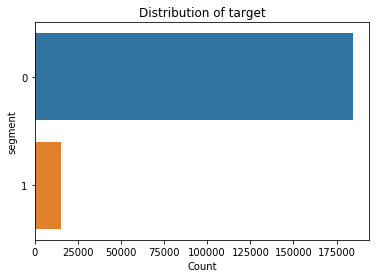

In [7]:
# Plotting distribution of Segments:
sns.countplot(y='segment', data=train_data)
plt.ylabel('segment')
plt.xlabel('Count')
plt.title('Distribution of target')
plt.show()

In [8]:
#check target variable count
train_data['segment'].value_counts()/train_data.shape[0]

0    0.923725
1    0.076275
Name: segment, dtype: float64

In [9]:
# Creating separate columns for genres
genre_data = [[str("genre_" + i) for i in re.sub(pattern='\:\d+',repl='',string=x).split(",")] for x in train_data['genres']]
genre_data = frozenset.union(*pd.Series(genre_data).apply(frozenset))

In [10]:
cities_data = [[str("cities_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['cities']]
cities_data = frozenset.union(*pd.Series(cities_data).apply(frozenset))

In [11]:
dow_data = [[str("dow_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['dow']]
dow_data = frozenset.union(*pd.Series(dow_data).apply(frozenset))

In [12]:
tod_data = [[str("tod_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['tod']]
tod_data = frozenset.union(*pd.Series(tod_data).apply(frozenset))

In [13]:
def get_genre_freq(row):
        
    genre_dict = {}
    for genre in row.genres.split(","):
        genre_name, genre_wt = genre.split(":")
        genre_dict[str("genre_" + genre_name)] = int(genre_wt)
    
    genre_freq = {}
    for i in genre_data:
        if i in genre_dict:
            genre_freq[i] = genre_dict[i] 
        else:
            genre_freq[i] = 0            

    return pd.Series(genre_freq)

In [14]:
genre_feats = train_data.progress_apply(get_genre_freq, axis = 1)

200001it [02:00, 1666.16it/s]


In [15]:
def get_dow_freq(row):
    
    dow_dict = {}
    for dow in row.dow.split(","):
        dow_name, dow_wt = dow.split(":")
        dow_dict[str("dow_" + dow_name)] = int(dow_wt)
    
    dow_freq = {}
    for i in dow_data:
        if i in dow_dict:
            dow_freq[i] = dow_dict[i] 
        else:
            dow_freq[i] = 0            

    return pd.Series(dow_freq)

def get_tod_freq(row):
    
    tod_dict = {}
    for tod in row.tod.split(","):
        tod_name, tod_wt = tod.split(":")
        tod_dict[str("tod_" + tod_name)] = int(tod_wt)
    
    tod_freq = {}
    for i in tod_data:
        if i in tod_dict:
            tod_freq[i] = tod_dict[i] 
        else:
            tod_freq[i] = 0            

    return pd.Series(tod_freq)

In [16]:
dow_feats = train_data.progress_apply(get_dow_freq, axis = 1)
tod_feats = train_data.progress_apply(get_tod_freq, axis = 1)

100%|██████████| 200000/200000 [01:28<00:00, 2249.63it/s]


In [17]:
train_data = pd.concat([train_data, genre_feats], axis = 1)
train_data = pd.concat([train_data, dow_feats], axis = 1)
train_data = pd.concat([train_data, tod_feats], axis = 1)

In [18]:
genre_feats = test_data.progress_apply(get_genre_freq, axis = 1)
dow_feats = test_data.progress_apply(get_dow_freq, axis = 1)
tod_feats = test_data.progress_apply(get_tod_freq, axis = 1)

test_data = pd.concat([test_data, genre_feats], axis = 1)
test_data = pd.concat([test_data, dow_feats], axis = 1)
test_data = pd.concat([test_data, tod_feats], axis = 1)

100%|██████████| 100000/100000 [00:45<00:00, 2221.44it/s]


In [19]:
metro_cities = ['mumbai','delhi','kolkata','chennai','bengaluru','hyderabad','ahmadabad','pune','surat','jaipur','kanpur','lucknow','nagpur','ghaziabad','indore','coimbatore','kochi','patna','kozhikode','bhopal','thrissur','vadodara','agra','malappuram','thiruvananthapuram','kannur','ludhiana','nashik','vijayawada','madurai','varanasi','meerut','faridabad','rajkot','jamshedpur','srinagar','jabalpur','asansol','vasai virar city','allahabad','dhanbad','aurangabad','amritsar','jodhpur','ranchi','raipur','kollam','gwalior','durg-bhilainagar','chandigarh','tiruchirappalli','kota']
cities_metro = ['metro','non_metro']
def get_Metro_freq(row):
    cities_dict = {}
    for city in row.cities.split(","):
        city_name, city_wt = city.split(":")
        if city_name.lower() in metro_cities:
            cities_dict[str("metro")] = int(city_wt)
        else:
            cities_dict[str("non_metro")] = int(city_wt)   
    
    metro_freq = {}
    for x in cities_metro:
        if x in cities_dict:
            metro_freq[x] = cities_dict[x]
        else:
            metro_freq[x] = 0            

    return pd.Series(metro_freq)

In [20]:
metro_feats = train_data.progress_apply(get_Metro_freq, axis = 1)

100%|██████████| 200000/200000 [01:21<00:00, 2459.79it/s]


In [21]:
train_data = pd.concat([train_data, metro_feats], axis = 1)
metro_feats

,metro,non_metro
0,64,0
1,26989,56666
2,0,29400
3,0,4005
4,0,2864
5,0,5
6,13142,3885
7,77,373
8,19504,1124
9,0,104


In [22]:
metro_feats = test_data.progress_apply(get_Metro_freq, axis = 1)
test_data = pd.concat([test_data, metro_feats], axis = 1)

100%|██████████| 100000/100000 [00:41<00:00, 2424.06it/s]


In [23]:
# sum of watch time from titles

def get_sum_wt(row):
    
    sum_wt = 0
    
    for title in row.titles.split(","):

        try: #to ignore blanks

            title_name, title_wt = title.split(":")
            sum_wt += int(title_wt)
            
        except:
            pass
        
    return sum_wt

train_data["sum_wt"] = train_data.progress_apply(get_sum_wt, axis = 1)
test_data["sum_wt"] = test_data.progress_apply(get_sum_wt, axis = 1)

100%|██████████| 100000/100000 [00:04<00:00, 23554.44it/s]


In [24]:
#Create Count variables
def get_count(feature):
    return feature.count(',')+1

train_data['title_count'] = train_data['titles'].map(get_count)
train_data['genres_count'] = train_data['genres'].map(get_count)
train_data['cities_count'] = train_data['cities'].map(get_count)
train_data['tod_count'] = train_data['tod'].map(get_count)
train_data['dow_count'] = train_data['dow'].map(get_count)

#test_data['title_count'] = test_data['titles'].map(get_count)
#test_data['genres_count'] = test_data['genres'].map(get_count)
#test_data['cities_count'] = test_data['cities'].map(get_count)
#test_data['tod_count'] = test_data['tod'].map(get_count)
#test_data['dow_count'] = test_data['dow'].map(get_count)



In [25]:
dow_1_sum= train_data['dow_1'].sum()
dow_2_sum= train_data['dow_2'].sum()
dow_3_sum= train_data['dow_3'].sum()
dow_4_sum= train_data['dow_4'].sum()
dow_5_sum= train_data['dow_5'].sum()
dow_6_sum= train_data['dow_6'].sum()
dow_7_sum= train_data['dow_7'].sum()
dow_sum=[dow_1_sum, dow_2_sum, dow_3_sum, dow_4_sum, dow_5_sum, dow_6_sum, dow_7_sum]
dow_sum

[565542985, 543678498, 540798186, 659711445, 593545037, 624329762, 721431991]

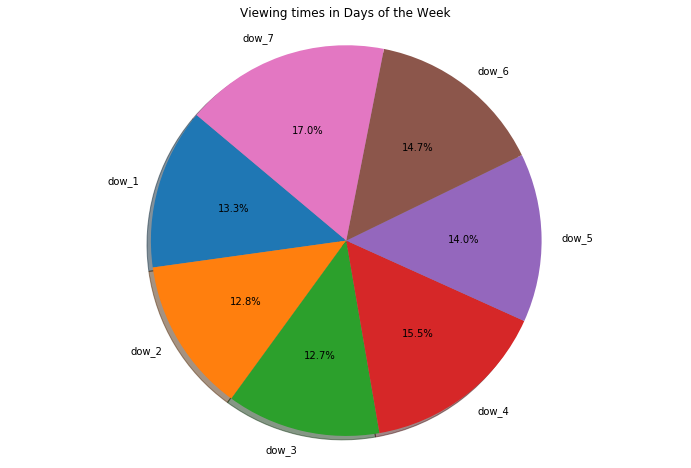

In [26]:
days_of_week = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red','yellow', 'cyan']
plt.figure(figsize=(12,8))
plt.pie(dow_sum, labels=['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6','dow_7'],
       autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Viewing times in Days of the Week')
plt.show()

In [27]:
train_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)
#test_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)

In [28]:
test_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)

In [29]:
train_data.to_csv('final_train_test.csv')

In [30]:
test_data.to_csv('final_test.csv')

In [31]:
#new_data_frame = train_data.copy()
#train_data = new_data_frame

In [32]:
train_data.columns


Index(['ID', 'segment', 'genre_Reality', 'genre_Crime', 'genre_Action',
       'genre_Table Tennis', 'genre_TalkShow', 'genre_Hockey',
       'genre_Wildlife', 'genre_Swimming', 'genre_Drama', 'genre_Mythology',
       'genre_Horror', 'genre_Sport', 'genre_Teen', 'genre_FormulaE',
       'genre_Boxing', 'genre_Cricket', 'genre_NA', 'genre_Athletics',
       'genre_IndiaVsSa', 'genre_LiveTV', 'genre_Romance', 'genre_Awards',
       'genre_Volleyball', 'genre_Travel', 'genre_Kabaddi', 'genre_Family',
       'genre_Comedy', 'genre_Kids', 'genre_Formula1', 'genre_Football',
       'genre_Tennis', 'genre_Badminton', 'genre_Documentary',
       'genre_Thriller', 'genre_Science', 'dow_2', 'dow_7', 'dow_3', 'dow_4',
       'dow_1', 'dow_6', 'dow_5', 'tod_16', 'tod_9', 'tod_14', 'tod_7',
       'tod_21', 'tod_17', 'tod_2', 'tod_8', 'tod_11', 'tod_4', 'tod_18',
       'tod_20', 'tod_5', 'tod_0', 'tod_13', 'tod_22', 'tod_6', 'tod_10',
       'tod_19', 'tod_12', 'tod_3', 'tod_23', 'tod_15', 'tod_1

In [33]:
def similar_genre_feature(df):
    
    sports_feats = ["genre_Athletics" , "genre_Badminton" , "genre_Boxing" , "genre_Cricket" , "genre_Football" , "genre_Formula1" , "genre_FormulaE" , "genre_Hockey" , "genre_IndiaVsSa" , "genre_Kabaddi" , "genre_Sport" , "genre_Swimming" , "genre_Table Tennis" , "genre_Tennis" , "genre_Volleyball"]
    df["generated_sports"] = 0
    
    remaining_genres = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller"]
    #df["generated_positive"] = 0

    remaining_genres = []
    
    for i in df.columns:
        if "genre_" in i and i not in sports_feats:
            remaining_genres.append(i)
    

    for i in sports_feats:
        df["generated_sports"]  = df["generated_sports"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = sum([df[i] for i in remaining_genres])
    sum_wt += df["generated_sports"]
    
    df["generated_sports_ratio"] = df["generated_sports"]/sum_wt    
    
    for i in remaining_genres:
        df[i+"_ratio"] = df[i]/sum_wt
            
    return df

In [34]:
def generate_tod_features(df):
    night_feats = ["tod_0", "tod_1", "tod_2", "tod_3", "tod_4", "tod_5"]
    df["generated_night"] = 0
    
    morning_feats = ["tod_6", "tod_7", "tod_8", "tod_9", "tod_10", "tod_11"]    
    df["generated_morning"] = 0
    
    afternoon_feats = ["tod_12", "tod_13", "tod_14", "tod_15", "tod_16", "tod_17"]    
    df["generated_afternoon"] = 0
    
    evening_feats = [ "tod_18", "tod_19", "tod_20", "tod_21", "tod_22", "tod_23"]    
    df["generated_evening"] = 0

    for i in night_feats:
        df["generated_night"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in morning_feats:
        df["generated_morning"] += df[i]
        df.drop(i, axis = 1, inplace = True)
        
    for i in afternoon_feats:
        df["generated_afternoon"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in evening_feats:
        df["generated_evening"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = df["generated_night"] + df["generated_morning"] + df["generated_afternoon"] + df["generated_evening"]

    df["night_tod_ratio"] = df["generated_night"]/sum_wt
    df["morning_tod_ratio"] = df["generated_morning"]/sum_wt
    df["afternoon_tod_ratio"] = df["generated_afternoon"]/sum_wt                                                  
    df["evening_tod_ratio"] = df["generated_evening"]/sum_wt
    
    return df

In [35]:
def generate_wod_features(df):

    weekday_feats = ["dow_1", "dow_2", "dow_3", "dow_4", "dow_5", "dow_6", "dow_7"]
    sum_wt = sum([df[i] for i in weekday_feats])
    df["weekend_ratio"] = (df["dow_7"] + df["dow_6"])/sum_wt
    df["weekday_ratio"] = 1 - df["weekend_ratio"]
    
    return df

In [36]:
def generate_cities_features(df):
    sum_wt = df["metro"] + df["non_metro"]
    df["metro_ratio"] = df["metro"]/sum_wt
    df["non_metro_ratio"] = df["non_metro"]/sum_wt
    return df

In [37]:
df_new = similar_genre_feature(train_data)

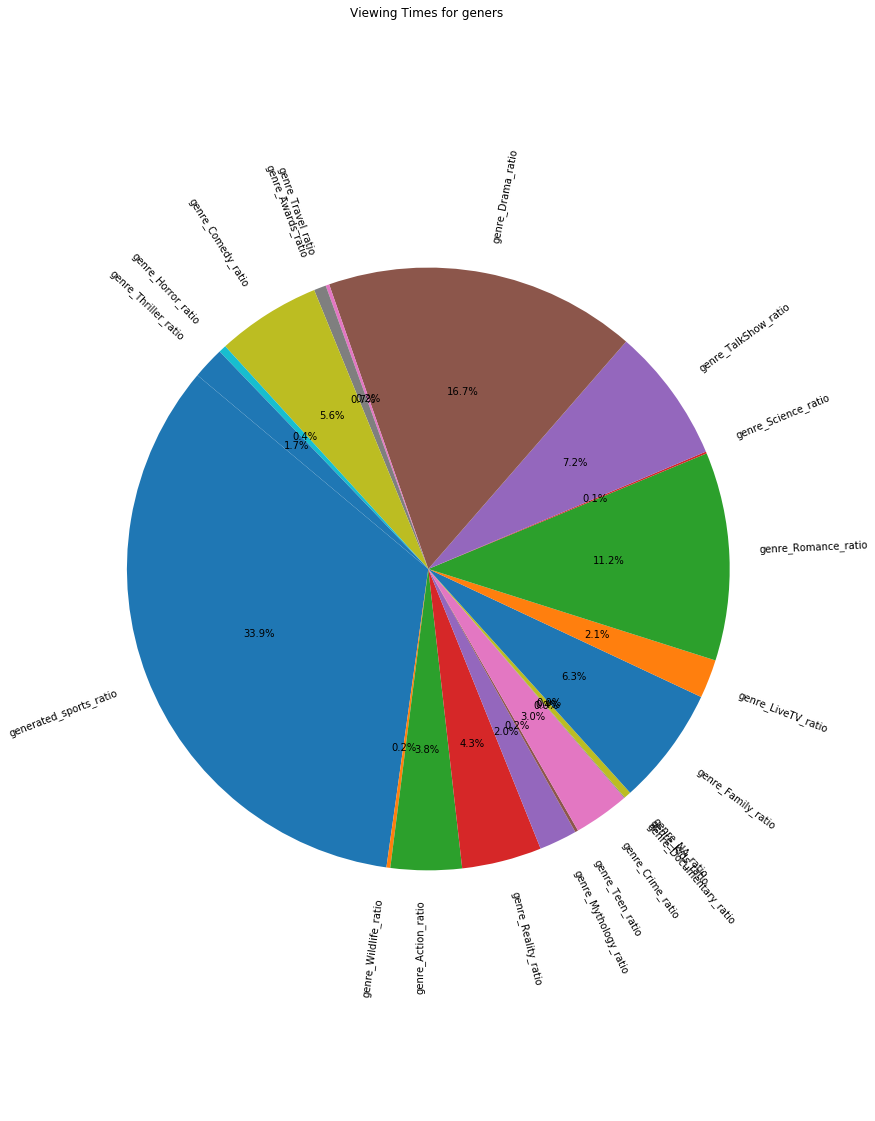

In [38]:
labels = ['generated_sports_ratio', 'genre_Wildlife_ratio',
       'genre_Action_ratio', 'genre_Reality_ratio', 'genre_Mythology_ratio',
       'genre_Teen_ratio', 'genre_Crime_ratio', 'genre_Documentary_ratio',
       'genre_Kids_ratio', 'genre_NA_ratio', 'genre_Family_ratio',
       'genre_LiveTV_ratio', 'genre_Romance_ratio', 'genre_Science_ratio',
       'genre_TalkShow_ratio', 'genre_Drama_ratio', 'genre_Travel_ratio',
       'genre_Awards_ratio', 'genre_Comedy_ratio', 'genre_Horror_ratio',
       'genre_Thriller_ratio']

sum_geners = [df_new['generated_sports_ratio'].sum(), df_new['genre_Wildlife_ratio'].sum(),
       df_new['genre_Action_ratio'].sum(), df_new['genre_Reality_ratio'].sum(), df_new['genre_Mythology_ratio'].sum(),
       df_new['genre_Teen_ratio'].sum(), df_new['genre_Crime_ratio'].sum(), df_new['genre_Documentary_ratio'].sum(),
       df_new['genre_Kids_ratio'].sum(), df_new['genre_NA_ratio'].sum(), df_new['genre_Family_ratio'].sum(),
       df_new['genre_LiveTV_ratio'].sum(), df_new['genre_Romance_ratio'].sum(), df_new['genre_Science_ratio'].sum(),
       df_new['genre_TalkShow_ratio'].sum(), df_new['genre_Drama_ratio'].sum(), df_new['genre_Travel_ratio'].sum(),
       df_new['genre_Awards_ratio'].sum(), df_new['genre_Comedy_ratio'].sum(), df_new['genre_Horror_ratio'].sum(),
       df_new['genre_Thriller_ratio'].sum()]
plt.figure(figsize=(12,20))
plt.pie(sum_geners, labels=labels,
       autopct='%1.1f%%',  startangle=140, rotatelabels=True)
plt.axis('equal')
plt.title('Viewing Times for geners')
plt.show()

In [39]:
df_new = generate_tod_features(train_data)

In [40]:
tod_sum_wt = [df_new["generated_night"].sum() , df_new["generated_afternoon"].sum() , df_new["generated_evening"].sum(),df_new["generated_morning"].sum()]
tod_sum_wt

[545548434, 1426059749, 1610752873, 666613752]

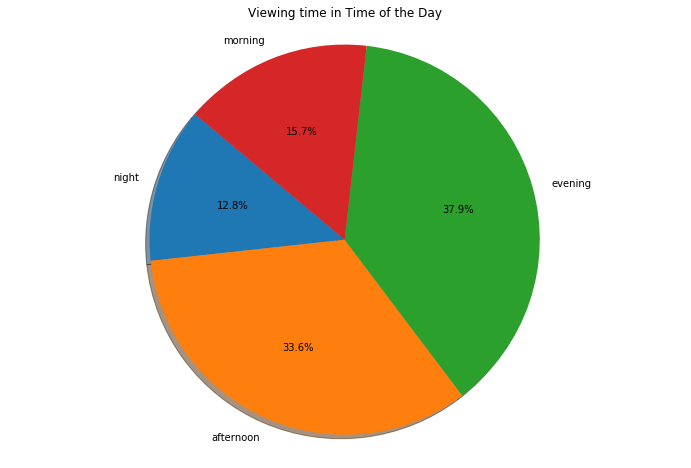

In [41]:
colors_tod = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.figure(figsize=(12,8))
plt.pie(tod_sum_wt, labels=['night','afternoon','evening','morning'],
       autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Viewing time in Time of the Day')
plt.show()

In [42]:
df_new = generate_wod_features(train_data)

In [43]:
df_new  = generate_cities_features(train_data)

In [44]:
df_new.to_csv('train_data_new.csv')

In [45]:
df_test_new = generate_tod_features(test_data)
df_test_new = similar_genre_feature(test_data)
df_test_new = generate_wod_features(test_data)
df_test_new  = generate_cities_features(test_data)

In [46]:
df_test_new.to_csv('test_data_new.csv')

/Users/amitagarwal/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


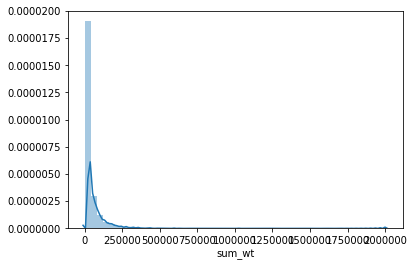

In [47]:
sns.distplot(df_new[df_new.segment == 1].sum_wt)
plt.show()

/Users/amitagarwal/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


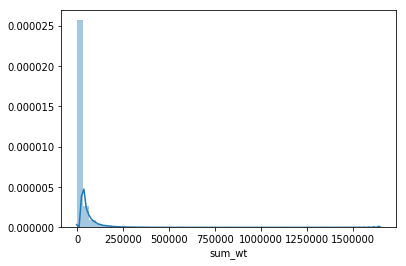

In [48]:
sns.distplot(df_new[df_new.segment == 0].sum_wt)
plt.show()

In [49]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000e+00
genre_Reality,15255.0,963.399869,5546.414251,0.0,0.000000,0.000000,1.000000,2.126130e+05
genre_Crime,15255.0,718.917339,7768.346332,0.0,0.000000,0.000000,0.000000,3.479850e+05
genre_Action,15255.0,368.571878,2618.270846,0.0,0.000000,0.000000,0.000000,1.695550e+05
genre_TalkShow,15255.0,3263.741265,8679.883676,0.0,0.000000,0.000000,1400.000000,1.711190e+05
genre_Wildlife,15255.0,8.800656,382.275589,0.0,0.000000,0.000000,0.000000,4.379900e+04
genre_Drama,15255.0,10814.095051,30646.106065,0.0,0.000000,456.000000,7896.000000,1.307902e+06
genre_Mythology,15255.0,586.506129,7512.388950,0.0,0.000000,0.000000,0.000000,3.414370e+05
genre_Horror,15255.0,66.417437,1009.797066,0.0,0.000000,0.000000,0.000000,5.945500e+04
genre_Teen,15255.0,229.727040,7055.379055,0.0,0.000000,0.000000,0.000000,6.054360e+05


In [50]:
Columns_needs_to_drop = ["generated_evening","generated_night","generated_afternoon","generated_morning","dow_1","dow_2","dow_3","dow_4","dow_5","dow_6","dow_7","metro","non_metro"]
df_new.drop(Columns_needs_to_drop,axis=1,inplace = True)

remaining_genres_columns = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller","sum_wt"]
df_new.drop(remaining_genres_columns,axis=1,inplace = True)

somemore_genres_columns = ["genre_Action", "genre_Documentary", "genre_Mythology", "genre_Teen", "genre_Crime", "genre_Kids", "genre_Science","genre_Horror","genre_Awards","genre_Travel","genre_NA","genre_LiveTV","genre_Wildlife","generated_sports"]
df_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [51]:
Columns_needs_to_drop = ["generated_evening","generated_night","generated_afternoon","generated_morning","dow_1","dow_2","dow_3","dow_4","dow_5","dow_6","dow_7","metro","non_metro"]
df_test_new.drop(Columns_needs_to_drop,axis=1,inplace = True)

remaining_genres_columns = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller","sum_wt"]
df_test_new.drop(remaining_genres_columns,axis=1,inplace = True)

somemore_genres_columns = ["genre_Action", "genre_Documentary", "genre_Mythology", "genre_Teen", "genre_Crime", "genre_Kids", "genre_Science","genre_Horror","genre_Awards","genre_Travel","genre_NA","genre_LiveTV","genre_Wildlife","generated_sports"]
df_test_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [94]:
#somemore_genres_columns = ["genre_LiveTV","genre_Wildlife","generated_sports"]
#df_test_new.drop(somemore_genres_columns,axis=1,inplace = True)

df_new.head(5)

,segment,genre_Wildlife,genre_LiveTV,generated_sports,generated_sports_ratio,genre_Reality_ratio,genre_Crime_ratio,genre_Action_ratio,genre_TalkShow_ratio,genre_Wildlife_ratio,...,genre_Thriller_ratio,genre_Science_ratio,night_tod_ratio,morning_tod_ratio,afternoon_tod_ratio,evening_tod_ratio,weekend_ratio,weekday_ratio,metro_ratio,non_metro_ratio
0,0,79,0,3469,0.976083,0.0,0.000000,0.000000,0.0,0.022228,...,0.0,0.0,0.000000,0.000000,0.090039,0.909961,0.018008,0.981992,1.000000,0.000000
1,0,0,0,0,0.000000,0.0,0.022729,0.024678,0.0,0.000000,...,0.0,0.0,0.300951,0.158450,0.237425,0.303175,0.485264,0.514736,0.322623,0.677377
2,0,0,4,5715,0.194401,0.0,0.000000,0.000476,0.0,0.000000,...,0.0,0.0,0.000000,0.301504,0.176453,0.522044,0.272758,0.727242,0.000000,1.000000
3,0,0,0,3883,0.951249,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.029887,0.970113,0.000000,0.000000,1.000000,0.000000,1.000000
4,1,0,0,0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


In [53]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
genre_Wildlife,15255.0,8.800656,382.275589,0.0,0.000000,0.000000,0.000000,43799.000000
genre_LiveTV,15255.0,77.338315,1519.662122,0.0,0.000000,0.000000,0.000000,155208.000000
title_count,15255.0,8.012455,9.835222,1.0,2.000000,5.000000,10.000000,186.000000
genres_count,15255.0,3.247263,2.071606,1.0,2.000000,3.000000,4.000000,18.000000
cities_count,15255.0,2.058276,1.352105,1.0,1.000000,2.000000,3.000000,16.000000
tod_count,15255.0,8.806490,6.005727,1.0,3.000000,8.000000,13.000000,24.000000
dow_count,15255.0,4.496296,2.284612,1.0,2.000000,5.000000,7.000000,7.000000
generated_sports,15255.0,845.520485,4928.095744,0.0,0.000000,0.000000,0.000000,145748.000000
generated_sports_ratio,15255.0,0.054075,0.190283,0.0,0.000000,0.000000,0.000000,1.000000


In [54]:
dropping_columns = ["ID", "dow_count", "tod_count", "genres_count", "cities_count", "title_count"]
df_new.drop(dropping_columns,axis=1,inplace = True)

In [55]:
dropping_columns = ["ID"]
df_test_new.drop(dropping_columns,axis=1,inplace = True)

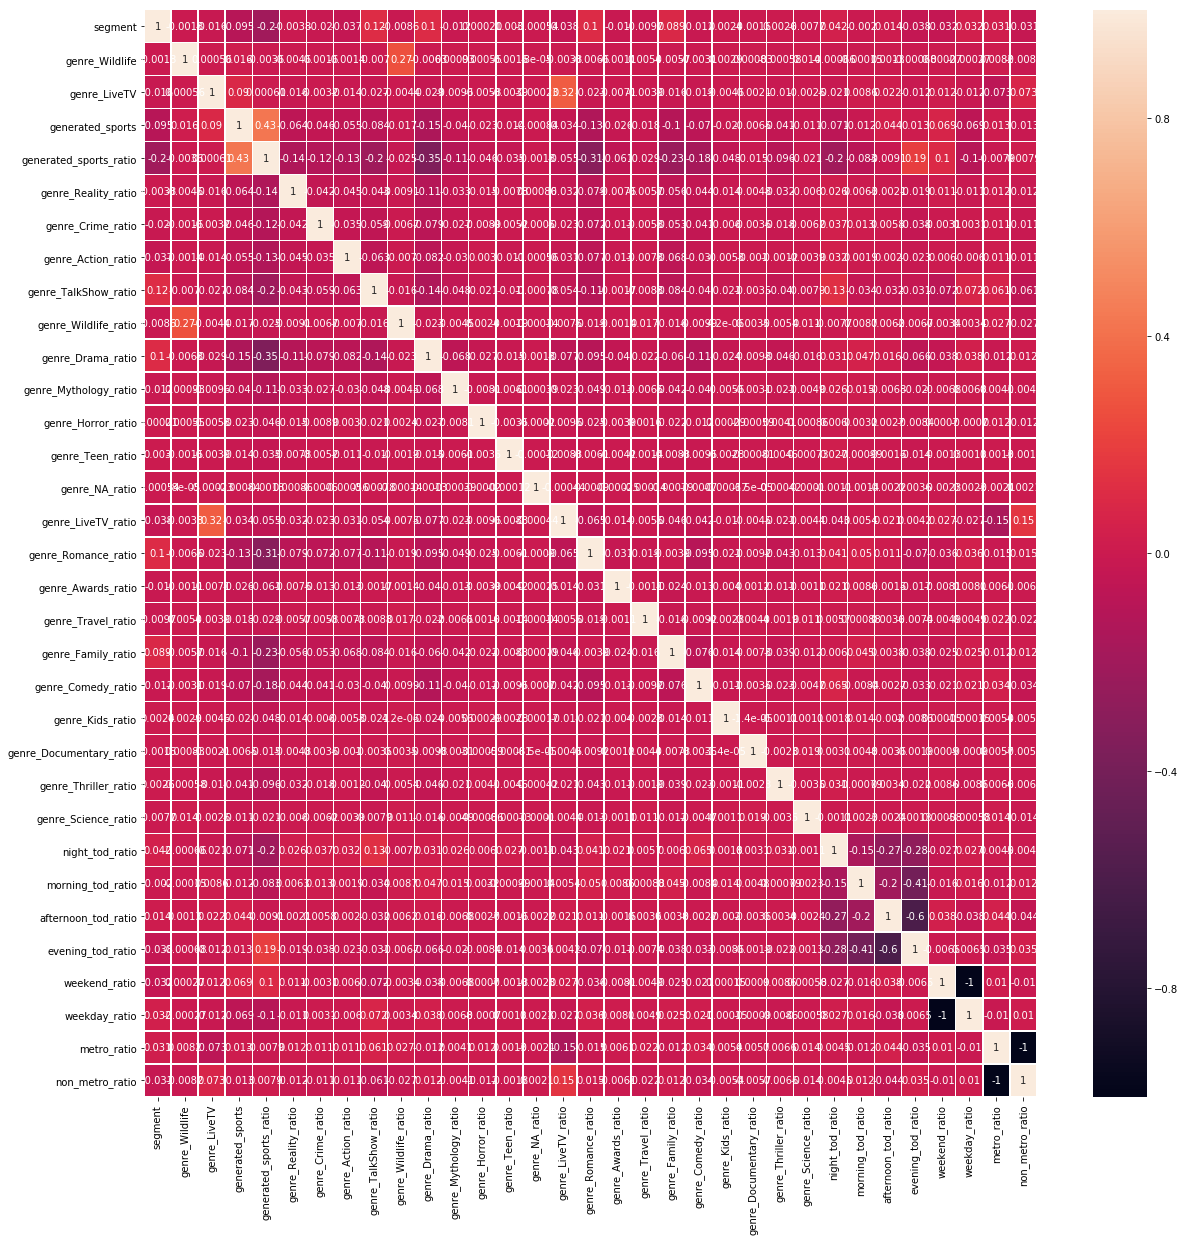

In [56]:
Var_Corr = df_new.corr()
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,linewidths=.5, ax=ax)

In [57]:
import matplotlib.pyplot as plt
plt.show()

In [58]:
# Plotting distribution of Segments:
#sns.countplot(y='metro_ratio', data=df_new)
#plt.ylabel('matro_ratio')
#plt.xlabel('Count')
#plt.title('Distribution of metros')
#plt.show()

In [59]:
df_new.to_csv('intermidate_state.csv')

In [60]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
genre_Wildlife,15255.0,8.800656,382.275589,0.0,0.000000,0.000000,0.000000,43799.000000
genre_LiveTV,15255.0,77.338315,1519.662122,0.0,0.000000,0.000000,0.000000,155208.000000
generated_sports,15255.0,845.520485,4928.095744,0.0,0.000000,0.000000,0.000000,145748.000000
generated_sports_ratio,15255.0,0.054075,0.190283,0.0,0.000000,0.000000,0.000000,1.000000
genre_Reality_ratio,15255.0,0.040708,0.155611,0.0,0.000000,0.000000,0.000013,1.000000
genre_Crime_ratio,15255.0,0.019839,0.114069,0.0,0.000000,0.000000,0.000000,1.000000
genre_Action_ratio,15255.0,0.018738,0.105561,0.0,0.000000,0.000000,0.000000,1.000000
genre_TalkShow_ratio,15255.0,0.160619,0.321409,0.0,0.000000,0.000000,0.085810,1.000000
genre_Wildlife_ratio,15255.0,0.001023,0.025014,0.0,0.000000,0.000000,0.000000,1.000000


In [61]:
df_new.to_csv('intermidate_state.csv')

In [62]:
#30 Features 
df_new.shape

(200000, 33)

In [63]:
df_test_new.shape

(100000, 29)

In [64]:
df_test_new[df_new.segment == 1].describe().transpose()

/Users/amitagarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,count,mean,std,min,25%,50%,75%,max
night_tod_ratio,7552.0,0.104841,0.223846,0.0,0.000000,0.000000,0.086322,1.000000
morning_tod_ratio,7552.0,0.138985,0.234613,0.0,0.000000,0.018586,0.181046,1.000000
afternoon_tod_ratio,7552.0,0.327197,0.318086,0.0,0.009734,0.254663,0.529071,1.000000
evening_tod_ratio,7552.0,0.428977,0.346156,0.0,0.103863,0.381930,0.713164,1.000000
generated_sports_ratio,7552.0,0.316528,0.399261,0.0,0.000000,0.019600,0.747262,0.999962
genre_Reality_ratio,7552.0,0.041446,0.157263,0.0,0.000000,0.000000,0.000430,1.000000
genre_Crime_ratio,7552.0,0.032312,0.147710,0.0,0.000000,0.000000,0.000000,1.000000
genre_Action_ratio,7552.0,0.036584,0.148080,0.0,0.000000,0.000000,0.000000,1.000000
genre_TalkShow_ratio,7552.0,0.090977,0.248763,0.0,0.000000,0.000000,0.001330,1.000000
genre_Wildlife_ratio,7552.0,0.002691,0.039402,0.0,0.000000,0.000000,0.000000,1.000000


In [65]:
df_new.columns

Index(['segment', 'genre_Wildlife', 'genre_LiveTV', 'generated_sports',
       'generated_sports_ratio', 'genre_Reality_ratio', 'genre_Crime_ratio',
       'genre_Action_ratio', 'genre_TalkShow_ratio', 'genre_Wildlife_ratio',
       'genre_Drama_ratio', 'genre_Mythology_ratio', 'genre_Horror_ratio',
       'genre_Teen_ratio', 'genre_NA_ratio', 'genre_LiveTV_ratio',
       'genre_Romance_ratio', 'genre_Awards_ratio', 'genre_Travel_ratio',
       'genre_Family_ratio', 'genre_Comedy_ratio', 'genre_Kids_ratio',
       'genre_Documentary_ratio', 'genre_Thriller_ratio',
       'genre_Science_ratio', 'night_tod_ratio', 'morning_tod_ratio',
       'afternoon_tod_ratio', 'evening_tod_ratio', 'weekend_ratio',
       'weekday_ratio', 'metro_ratio', 'non_metro_ratio'],
      dtype='object')

In [66]:
df_test_new.columns

Index(['night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio',
       'evening_tod_ratio', 'generated_sports_ratio', 'genre_Reality_ratio',
       'genre_Crime_ratio', 'genre_Action_ratio', 'genre_TalkShow_ratio',
       'genre_Wildlife_ratio', 'genre_Drama_ratio', 'genre_Mythology_ratio',
       'genre_Horror_ratio', 'genre_Teen_ratio', 'genre_NA_ratio',
       'genre_LiveTV_ratio', 'genre_Romance_ratio', 'genre_Awards_ratio',
       'genre_Travel_ratio', 'genre_Family_ratio', 'genre_Comedy_ratio',
       'genre_Kids_ratio', 'genre_Documentary_ratio', 'genre_Thriller_ratio',
       'genre_Science_ratio', 'weekend_ratio', 'weekday_ratio', 'metro_ratio',
       'non_metro_ratio'],
      dtype='object')

In [67]:
df_test_new["segment"] = np.nan

In [68]:
df_test_new.to_csv('final_test_data.csv')

In [86]:
df_test_new = pd.read_csv('final_test_data.csv')

In [107]:
df_test_new["segment"] = np.nan

In [87]:
from __future__ import division
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split

In [132]:
def run_xgb_5(x_train, label_train, x_valid = None, label_valid = None):

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    params['eta'] = 0.02
    params['max_depth'] = 5
    params['silent'] = 1
    params['min_child_weight'] = 0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params['nthread'] = 13

    d_train = xgb.DMatrix(x_train, label=label_train)
    
    if x_valid is not None:
        d_valid = xgb.DMatrix(x_valid, label=label_valid)
        watchlist = [(d_train, 'train'), (d_valid, 'validation')]
    else:
        watchlist = [(d_train, 'train')]
        
    bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    return bst

In [133]:
#Clean useless columns
df_train = df_new.drop("segment",axis=1)
df_train_target = df_new["segment"]
#df_new.drop("ID", axis = 1, inplace=True)

#Validation split
x_train, x_test, y_train, y_test = train_test_split(df_train, df_train_target, test_size=0.2, random_state=4242, stratify = df_train_target)


In [134]:
#Validation Run
bst5 = run_xgb_5(x_train, y_train, x_test, y_test)


[0]	train-auc:0.77635	validation-auc:0.771848
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 50 rounds.
[50]	train-auc:0.807624	validation-auc:0.801221
[100]	train-auc:0.810768	validation-auc:0.803272
[150]	train-auc:0.814483	validation-auc:0.80504
[200]	train-auc:0.817636	validation-auc:0.806329
[250]	train-auc:0.820825	validation-auc:0.807214
[300]	train-auc:0.823743	validation-auc:0.80771
[350]	train-auc:0.826203	validation-auc:0.807995
[400]	train-auc:0.828463	validation-auc:0.80811
[450]	train-auc:0.83049	validation-auc:0.808156
Stopping. Best iteration:
[413]	train-auc:0.828939	validation-auc:0.808176



In [135]:
from sklearn import metrics 


In [185]:
from sklearn import metrics 
d_test = xgb.DMatrix(x_test)
p5_test = bst5.predict(d_test)

p5_test = np.where(p5_test > 0.2, 1, 0)

In [186]:
print(metrics.confusion_matrix(y_test,p5_test))

[[34107  2842]
 [ 1924  1127]]


In [187]:
from sklearn.metrics import classification_report

print(classification_report(y_test,p5_test))

             precision    recall  f1-score   support

          0       0.95      0.92      0.93     36949
          1       0.28      0.37      0.32      3051

avg / total       0.90      0.88      0.89     40000



In [188]:
import operator
importance = bst5.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore']/df_imp['fscore'].sum()

df_imp

,feature,fscore
0,genre_NA_ratio,0.000512
1,genre_Documentary_ratio,0.002415
2,genre_Wildlife,0.006075
3,genre_Science_ratio,0.006441
4,genre_Wildlife_ratio,0.006880
5,non_metro_ratio,0.008344
6,genre_Teen_ratio,0.009003
7,genre_Horror_ratio,0.009369
8,genre_Travel_ratio,0.009442
9,weekday_ratio,0.016689


--------------------
--------------------


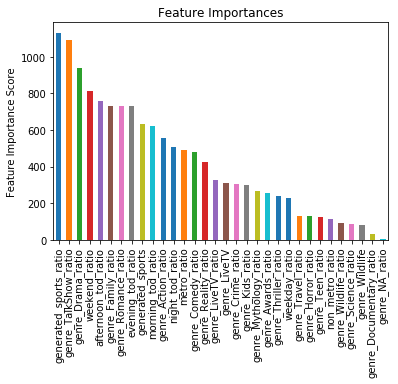

In [189]:
import operator
importance = bst5.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
print("--"*10)
df_imp = pd.Series(bst5.get_fscore()).sort_values(ascending=False)
df_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
print("--"*10)

In [190]:
bst5_roc_auc = roc_auc_score(y_test, (p5_test))
print('AUC_ROC Score is:' + str(bst5_roc_auc))

AUC_ROC Score is:0.6462351274466132


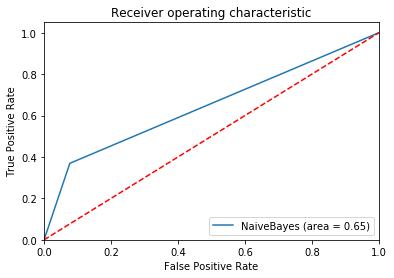

In [191]:
fpr, tpr, thresholds = roc_curve(y_test, p5_test)
plt.figure()
plt.plot(fpr, tpr, label='NaiveBayes (area = %0.2f)' % bst5_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [147]:
#Find Roc_Auc Score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
XG5_Boost_roc_auc = roc_auc_score(y_test, (p5_test))
#print('AUC_ROC Score is:' + str(XG5_Boost_roc_auc))

AUC_ROC Score is:0.5001638806948542


In [110]:
#Real Test Run + Submit
bst = run_xgb(df_train, df_train_target)

d_test = xgb.DMatrix(df_test_new)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
#sub['ID'] = test_ids
sub['segment'] = p_test
#sub.to_csv("./subs/xgb_1.csv", index=False)



[0]	train-auc:0.770922
Will train until train-auc hasn't improved in 50 rounds.
[50]	train-auc:0.80709
[100]	train-auc:0.809314
[150]	train-auc:0.812892
[200]	train-auc:0.815816
[250]	train-auc:0.818523
[300]	train-auc:0.821046
[350]	train-auc:0.823147
[400]	train-auc:0.825042
[450]	train-auc:0.826927
[499]	train-auc:0.828619


ValueError: feature_names mismatch: ['genre_Wildlife', 'genre_LiveTV', 'generated_sports', 'generated_sports_ratio', 'genre_Reality_ratio', 'genre_Crime_ratio', 'genre_Action_ratio', 'genre_TalkShow_ratio', 'genre_Wildlife_ratio', 'genre_Drama_ratio', 'genre_Mythology_ratio', 'genre_Horror_ratio', 'genre_Teen_ratio', 'genre_NA_ratio', 'genre_LiveTV_ratio', 'genre_Romance_ratio', 'genre_Awards_ratio', 'genre_Travel_ratio', 'genre_Family_ratio', 'genre_Comedy_ratio', 'genre_Kids_ratio', 'genre_Documentary_ratio', 'genre_Thriller_ratio', 'genre_Science_ratio', 'night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio', 'evening_tod_ratio', 'weekend_ratio', 'weekday_ratio', 'metro_ratio', 'non_metro_ratio'] ['Unnamed: 0', 'night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio', 'evening_tod_ratio', 'generated_sports_ratio', 'genre_Reality_ratio', 'genre_Crime_ratio', 'genre_Action_ratio', 'genre_TalkShow_ratio', 'genre_Wildlife_ratio', 'genre_Drama_ratio', 'genre_Mythology_ratio', 'genre_Horror_ratio', 'genre_Teen_ratio', 'genre_NA_ratio', 'genre_LiveTV_ratio', 'genre_Romance_ratio', 'genre_Awards_ratio', 'genre_Travel_ratio', 'genre_Family_ratio', 'genre_Comedy_ratio', 'genre_Kids_ratio', 'genre_Documentary_ratio', 'genre_Thriller_ratio', 'genre_Science_ratio', 'weekend_ratio', 'weekday_ratio', 'metro_ratio', 'non_metro_ratio', 'segment']
expected genre_LiveTV, genre_Wildlife, generated_sports in input data
training data did not have the following fields: segment, Unnamed: 0

In [121]:
def run_xgb(x_train, label_train, x_valid = None, label_valid = None):

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    params['eta'] = 0.02
    params['max_depth'] = 3
    params['silent'] = 1
    params['min_child_weight'] = 0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params['nthread'] = 13

    d_train = xgb.DMatrix(x_train, label=label_train)
    
    if x_valid is not None:
        d_valid = xgb.DMatrix(x_valid, label=label_valid)
        watchlist = [(d_train, 'train'), (d_valid, 'validation')]
    else:
        watchlist = [(d_train, 'train')]
        
    bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    return bst

In [122]:
#Clean useless columns
df_train = df_new.drop("segment",axis=1)
df_train_target = df_new["segment"]
#df_new.drop("ID", axis = 1, inplace=True)

#Validation split
x_train, x_test, y_train, y_test = train_test_split(df_train, df_train_target, test_size=0.2, random_state=4242, stratify = df_train_target)


In [123]:
#Validation Run
bst = run_xgb(x_train, y_train, x_test, y_test)


[0]	train-auc:0.762989	validation-auc:0.757828
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 50 rounds.
[50]	train-auc:0.79527	validation-auc:0.791816
[100]	train-auc:0.799443	validation-auc:0.796127
[150]	train-auc:0.802603	validation-auc:0.799096
[200]	train-auc:0.805174	validation-auc:0.801128
[250]	train-auc:0.807713	validation-auc:0.803017
[300]	train-auc:0.80955	validation-auc:0.804171
[350]	train-auc:0.811224	validation-auc:0.805152
[400]	train-auc:0.812511	validation-auc:0.805717
[450]	train-auc:0.813583	validation-auc:0.806119
[499]	train-auc:0.814474	validation-auc:0.806461


In [193]:
from sklearn import metrics 
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

p_test = np.where(p_test > 0.2, 1, 0)

In [194]:
print(metrics.confusion_matrix(y_test,p_test))

[[34167  2782]
 [ 1980  1071]]


In [195]:
from sklearn.metrics import classification_report

print(classification_report(y_test,p_test))

             precision    recall  f1-score   support

          0       0.95      0.92      0.93     36949
          1       0.28      0.35      0.31      3051

avg / total       0.89      0.88      0.89     40000



--------------------
--------------------


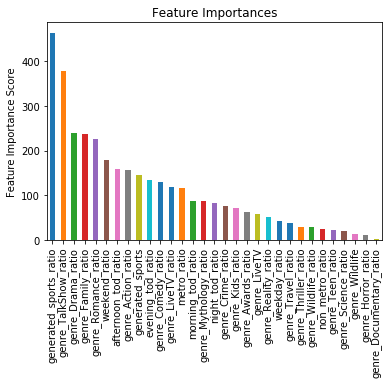

In [197]:
import operator
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
print("--"*10)
df_imp = pd.Series(bst.get_fscore()).sort_values(ascending=False)
df_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
print("--"*10)

In [198]:
bst3_roc_auc = roc_auc_score(y_test, (p_test))
print('AUC_ROC Score is:' + str(bst3_roc_auc))

AUC_ROC Score is:0.6378697384922899


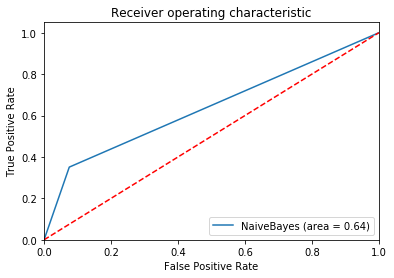

In [199]:
fpr, tpr, thresholds = roc_curve(y_test, p_test)
plt.figure()
plt.plot(fpr, tpr, label='NaiveBayes (area = %0.2f)' % bst3_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [146]:
import operator
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore']/df_imp['fscore'].sum()

df_imp

,feature,fscore
0,genre_Documentary_ratio,0.000286
1,genre_Horror_ratio,0.002858
2,genre_Wildlife,0.004001
3,genre_Science_ratio,0.005716
4,genre_Teen_ratio,0.006288
5,non_metro_ratio,0.006859
6,genre_Thriller_ratio,0.008574
7,genre_Wildlife_ratio,0.008574
8,genre_Travel_ratio,0.010860
9,weekday_ratio,0.012289


In [155]:
def run_xgb_8(x_train, label_train, x_valid = None, label_valid = None):

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    params['eta'] = 0.02
    params['max_depth'] = 8
    params['silent'] = 1
    params['min_child_weight'] = 0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params['nthread'] = 13

    d_train = xgb.DMatrix(x_train, label=label_train)
    
    if x_valid is not None:
        d_valid = xgb.DMatrix(x_valid, label=label_valid)
        watchlist = [(d_train, 'train'), (d_valid, 'validation')]
    else:
        watchlist = [(d_train, 'train')]
        
    bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    return bst

In [156]:
#Clean useless columns
df_train = df_new.drop("segment",axis=1)
df_train_target = df_new["segment"]
#df_new.drop("ID", axis = 1, inplace=True)

#Validation split
x_train, x_test, y_train, y_test = train_test_split(df_train, df_train_target, test_size=0.2, random_state=4242, stratify = df_train_target)


In [158]:
#Validation Run
bst8 = run_xgb_8(x_train, y_train, x_test, y_test)


[0]	train-auc:0.789438	validation-auc:0.779288
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 50 rounds.
[50]	train-auc:0.831421	validation-auc:0.804262
[100]	train-auc:0.839127	validation-auc:0.805425
[150]	train-auc:0.84771	validation-auc:0.806347
[200]	train-auc:0.855874	validation-auc:0.806992
[250]	train-auc:0.863453	validation-auc:0.807277
[300]	train-auc:0.869843	validation-auc:0.80714
Stopping. Best iteration:
[252]	train-auc:0.863756	validation-auc:0.807286



In [200]:
from sklearn import metrics 
d_test = xgb.DMatrix(x_test)
p8_test = bst8.predict(d_test)

p8_test = np.where(p_test > 0.2, 1, 0)

In [201]:
import operator
importance = bst8.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore']/df_imp['fscore'].sum()

df_imp

,feature,fscore
0,genre_NA_ratio,0.000388
1,genre_Documentary_ratio,0.002811
2,genre_Science_ratio,0.003310
3,genre_Wildlife_ratio,0.004087
4,genre_Wildlife,0.005899
5,genre_Teen_ratio,0.006490
6,genre_Travel_ratio,0.007138
7,non_metro_ratio,0.009763
8,genre_Horror_ratio,0.011834
9,genre_Awards_ratio,0.014331


In [202]:
from sklearn.metrics import classification_report

print(classification_report(y_test,p8_test))

             precision    recall  f1-score   support

          0       0.95      0.92      0.93     36949
          1       0.28      0.35      0.31      3051

avg / total       0.89      0.88      0.89     40000



--------------------
--------------------


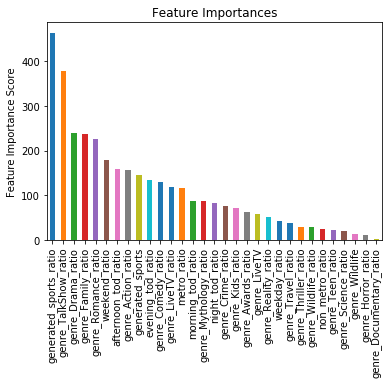

In [205]:
import operator
importance = bst8.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
print("--"*10)
df_imp = pd.Series(bst.get_fscore()).sort_values(ascending=False)
df_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
print("--"*10)

In [206]:
bst8_roc_auc = roc_auc_score(y_test, (p8_test))
print('AUC_ROC Score is:' + str(bst8_roc_auc))

AUC_ROC Score is:0.6378697384922899


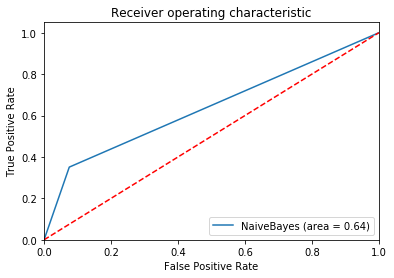

In [207]:
fpr, tpr, thresholds = roc_curve(y_test, p8_test)
plt.figure()
plt.plot(fpr, tpr, label='NaiveBayes (area = %0.2f)' % bst8_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [208]:
#Real Test Run + Submit
bst = run_xgb(df_train, df_train_target)

d_test = xgb.DMatrix(df_test_new)
p_final = bst5.predict(d_test)

sub = pd.DataFrame()
sub['segment'] = p_final


[0]	train-auc:0.753416
Will train until train-auc hasn't improved in 50 rounds.
[50]	train-auc:0.796087
[100]	train-auc:0.798721
[150]	train-auc:0.802173
[200]	train-auc:0.804672
[250]	train-auc:0.806925
[300]	train-auc:0.808699
[350]	train-auc:0.810166
[400]	train-auc:0.81134
[450]	train-auc:0.812312
[499]	train-auc:0.813185


ValueError: feature_names mismatch: ['genre_Wildlife', 'genre_LiveTV', 'generated_sports', 'generated_sports_ratio', 'genre_Reality_ratio', 'genre_Crime_ratio', 'genre_Action_ratio', 'genre_TalkShow_ratio', 'genre_Wildlife_ratio', 'genre_Drama_ratio', 'genre_Mythology_ratio', 'genre_Horror_ratio', 'genre_Teen_ratio', 'genre_NA_ratio', 'genre_LiveTV_ratio', 'genre_Romance_ratio', 'genre_Awards_ratio', 'genre_Travel_ratio', 'genre_Family_ratio', 'genre_Comedy_ratio', 'genre_Kids_ratio', 'genre_Documentary_ratio', 'genre_Thriller_ratio', 'genre_Science_ratio', 'night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio', 'evening_tod_ratio', 'weekend_ratio', 'weekday_ratio', 'metro_ratio', 'non_metro_ratio'] ['Unnamed: 0', 'night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio', 'evening_tod_ratio', 'generated_sports_ratio', 'genre_Reality_ratio', 'genre_Crime_ratio', 'genre_Action_ratio', 'genre_TalkShow_ratio', 'genre_Wildlife_ratio', 'genre_Drama_ratio', 'genre_Mythology_ratio', 'genre_Horror_ratio', 'genre_Teen_ratio', 'genre_NA_ratio', 'genre_LiveTV_ratio', 'genre_Romance_ratio', 'genre_Awards_ratio', 'genre_Travel_ratio', 'genre_Family_ratio', 'genre_Comedy_ratio', 'genre_Kids_ratio', 'genre_Documentary_ratio', 'genre_Thriller_ratio', 'genre_Science_ratio', 'weekend_ratio', 'weekday_ratio', 'metro_ratio', 'non_metro_ratio', 'segment']
expected genre_LiveTV, genre_Wildlife, generated_sports in input data
training data did not have the following fields: segment, Unnamed: 0

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
    print(precision_score(y_test, y_pred, average="macro"))
    print(recall_score(y_test, y_pred, average="macro"))  